In [1]:
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(f"detected {len(gpus)} gpus")

detected 1 gpus


### settings

In [3]:
LABELS = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

EPOCHS = 100
LR = 0.010
IMAGE_SIZE = (224,224,3)
BATCH_SIZE = 16

In [4]:
dataset = tfds.load("oxford_flowers102")
train_dataset = dataset["test"] 
test_dataset = dataset["train"]
val_dataset = dataset["validation"]

### Dataset utils

In [5]:
def preprocess_data(sample): 
    """
        Simply return the image and the label
    """
    
    image =  tf.image.resize(sample["image"],IMAGE_SIZE[:2])
    print(image.shape)
    label = sample["label"]
    
    return image, label


def display_grids(data):
    """
        Argument: 
            data : a batched dataset
    """
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1): 
        for i in range(9): 
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(LABELS[int(labels[i])])
            plt.axis("off")
    
    plt.show()
    

### quickly exploring the dataset : we will have to resize each image to a commin image size

In [6]:
for sample in train_dataset.take(2): 
    print(sample["image"].shape)

(542, 500, 3)
(748, 500, 3)


In [7]:
train_dataset = train_dataset.map(preprocess_data) 
test_dataset = test_dataset.map(preprocess_data) 
val_dataset = val_dataset.map(preprocess_data)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [8]:
for image, label in train_dataset.take(2): 
    print(image.shape)

(224, 224, 3)
(224, 224, 3)


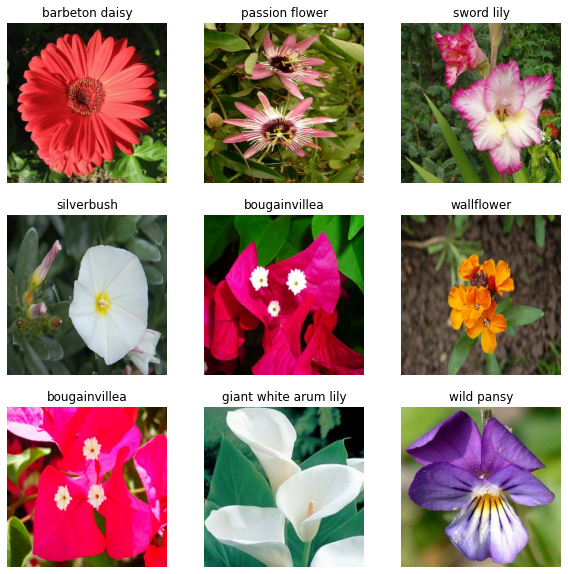

In [9]:
display_grids(train_dataset.batch(BATCH_SIZE))

### Transfer learning

#### We will use the Xception pretrained model, and will fine-tune it to get maximum performance on our dataset


### Let's define a data augmentation pipeline

In [10]:
def data_augm(input_shape=IMAGE_SIZE): 
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
    outputs = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[outputs])
    

In [11]:
def get_xception(image_size=IMAGE_SIZE): 
    
    model = tf.keras.applications.Xception(
        include_top=False, 
        input_shape=image_size, 
        classes=len(LABELS)
    )
    
    model.trainable = False
    
    return model

In [12]:
xception_model = get_xception()

#### Xception topology

In [13]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Custom top layers

In [14]:
def build_model(input_shape=IMAGE_SIZE): 
    
    inputs = tf.keras.Input(shape=input_shape)
    
    xception_model = get_xception()
    data_augm_pipeline = data_augm(input_shape)
    
    x = data_augm_pipeline(inputs)
    x = tf.keras.applications.xception.preprocess_input(x) 
    
    x = xception_model(x) 
    
    x = tf.keras.layers.Conv2D(256, 1, strides=2,padding="valid", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=1,padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 1, strides=1,padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(len(LABELS))(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
    

In [15]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 256)         1024

### model training

In [16]:
train_dataset = train_dataset.batch(BATCH_SIZE) 
val_dataset = val_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
def lrdecay(epoch, lr): 
    k = 0.01
    if epoch >=20: 
        k = 0.06
    elif epoch >=30: 
        k = 0.1
    
    if epoch >= 10: 
        return lr * np.exp(-k*epoch)
    else: 
        return lr
    
    
def lrdecay2(epoch, lr): 
    k = 1
    
    if epoch >= 10: 
        k = 0.95
    elif epoch >=20: 
        k = 0.954
    
    return LR * k**epoch

In [18]:
log_dir = f"logs/fit/xception_tl_lr={LR}_learningrate-decay_3_dropout=0.3_rmsprop_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True, verbose=1), 
    tf.keras.callbacks.LearningRateScheduler(lrdecay, verbose=1)
]

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [20]:
model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset
)

/home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
385/385 [==============================] - 45s 103ms/step - loss: 3.1790 - accuracy: 0.2571 - val_loss: 3.1723 - val_accuracy: 0.3382

Epoch 00001: val_loss improved from inf to 3.17225, saving model to best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
385/385 [==============================] - 37s 96ms/step - loss: 2.0372 - accuracy: 0.4890 - val_loss: 2.2880 - val_accuracy: 0.4775

Epoch 00002: val_loss improved from 3.17225 to 2.28800, saving model to best_model.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
385/385 [==============================] - 37s 96ms/step - loss: 1.5662 - accuracy: 0.6016 - val_loss: 2.2200 - val_accuracy: 0.5088

Epoch 00003: val_loss improved from 2.28800 to 2.22002, saving model to best_model.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler reducin


Epoch 00027: val_loss did not improve from 0.73334
Epoch 28/100

Epoch 00028: LearningRateScheduler reducing learning rate to 2.9609509133655404e-08.
385/385 [==============================] - 37s 96ms/step - loss: 0.1758 - accuracy: 0.9639 - val_loss: 0.7356 - val_accuracy: 0.8490

Epoch 00028: val_loss did not improve from 0.73334
Epoch 29/100

Epoch 00029: LearningRateScheduler reducing learning rate to 5.518442016126784e-09.
385/385 [==============================] - 37s 96ms/step - loss: 0.1876 - accuracy: 0.9639 - val_loss: 0.7349 - val_accuracy: 0.8490

Epoch 00029: val_loss did not improve from 0.73334
Epoch 30/100

Epoch 00030: LearningRateScheduler reducing learning rate to 9.685991765441788e-10.
385/385 [==============================] - 37s 96ms/step - loss: 0.1853 - accuracy: 0.9637 - val_loss: 0.7361 - val_accuracy: 0.8510

Epoch 00030: val_loss did not improve from 0.73334
Epoch 31/100

Epoch 00031: LearningRateScheduler reducing learning rate to 1.6010837103210942e-10.

385/385 [==============================] - 37s 96ms/step - loss: 0.1896 - accuracy: 0.9636 - val_loss: 0.7355 - val_accuracy: 0.8490

Epoch 00056: val_loss did not improve from 0.73080
Epoch 57/100

Epoch 00057: LearningRateScheduler reducing learning rate to 5.409913679442247e-40.
385/385 [==============================] - 37s 96ms/step - loss: 0.1750 - accuracy: 0.9681 - val_loss: 0.7397 - val_accuracy: 0.8500

Epoch 00057: val_loss did not improve from 0.73080
Epoch 58/100

Epoch 00058: LearningRateScheduler reducing learning rate to 1.769712930255839e-41.
385/385 [==============================] - 37s 96ms/step - loss: 0.1712 - accuracy: 0.9631 - val_loss: 0.7345 - val_accuracy: 0.8500

Epoch 00058: val_loss did not improve from 0.73080
Epoch 59/100

Epoch 00059: LearningRateScheduler reducing learning rate to 5.451987008575511e-43.
385/385 [==============================] - 37s 96ms/step - loss: 0.1788 - accuracy: 0.9632 - val_loss: 0.7400 - val_accuracy: 0.8510

Epoch 00059: val_


Epoch 00086: val_loss did not improve from 0.72925
Epoch 87/100

Epoch 00087: LearningRateScheduler reducing learning rate to 0.0.
385/385 [==============================] - 37s 96ms/step - loss: 0.1767 - accuracy: 0.9662 - val_loss: 0.7328 - val_accuracy: 0.8510

Epoch 00087: val_loss did not improve from 0.72925
Epoch 88/100

Epoch 00088: LearningRateScheduler reducing learning rate to 0.0.
385/385 [==============================] - 37s 96ms/step - loss: 0.1842 - accuracy: 0.9662 - val_loss: 0.7320 - val_accuracy: 0.8490

Epoch 00088: val_loss did not improve from 0.72925
Epoch 89/100

Epoch 00089: LearningRateScheduler reducing learning rate to 0.0.
385/385 [==============================] - 37s 96ms/step - loss: 0.1832 - accuracy: 0.9593 - val_loss: 0.7352 - val_accuracy: 0.8529

Epoch 00089: val_loss did not improve from 0.72925
Epoch 90/100

Epoch 00090: LearningRateScheduler reducing learning rate to 0.0.
385/385 [==============================] - 37s 96ms/step - loss: 0.1801 -